1. data ingestion
2. data cleanup
3. denoising?
4. expected value above x


**Notes:** Long term price behaviour fits onto a logistic curve for all stocks

## Market dynamics
We know there are (stochastic) volatility clusters, but in that respect there must be more to add to the risk side. \
We know there are trends, but that returns are "mostly" mean reverting even so. \
We know prices are mean-reverting around "plateaus" and that this can be described in some way with the lagrangian -taxonomic clusterings? \
We know that order imbalance plays a somewhat big role in pricing and an even bigger part in short-term pricing \

drift/trend) + feedback(self-reinforcement) + friction(liquidity) + shock + constraint(bound limits)


A + B(t_c - t)**2 * [1+C cos(w ln(t_c - t) + y)] 


persistence drag
shock dissipation - dissipation/stabilization
crowding/saturation - feedback loops
trend intensity decay - trend-reinforcing pressure
factor-sector coupling
return accumulatuin nodes - return driven drift
structural break zones
taxonomic clusterings?
regime dynamics regime evolution flow - baseline regime flow - cyclical regime forcing
mean reversion tension - pressure
nonlinear amplification
spatial smoothing
net directional drift / risk scaled normalization
baseline carry
phase rotation
return driven rotation
momemtum latitude bias
volatility banding
state hotspot
rotational turbulence
vol phase shift, time rotation
momentum tilt

drift term = systematic carry from being long/short volatility risk premia

price = (friction / sqrt(t) * implied volatility) * K(integral over measurable set of f_t(x,y) * wave-probability_t(x,y) divided by the f_t(x,y) lim at inf.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings('ignore') # Hide all warnings

from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import curve_fit
import inspect
from dataclasses import dataclass
from typing import Callable, Dict, Tuple, Optional, List


In [103]:
# ---------- Candidate models ----------
def linear(t, a, b):
    return a + b*t

def expo(t, a, b):
    # unbounded exponential
    return a * np.exp(b*t)

def log_curve(t, a, b, c):
    # logarithmic growth (needs t > -c)
    return a + b*np.log(t + c)

def sat_exp(t, L, k, t0):
    # saturating exponential toward ceiling L
    # starts near 0 when t << t0 if you set t0 accordingly
    return L * (1 - np.exp(-k*(t - t0)))

def logistic(t, L, k, t_mid):
    # logistic with ceiling L and midpoint t_mid
    return L / (1 + np.exp(-k*(t - t_mid)))

# Model
def logistic_model(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))


def model_4pl(x, A, L, k, x0):
    return A + (L - A) / (1 + np.exp(-k * (x - x0)))

def model_gompertz(x, L, k, x0):
    return L * np.exp(-np.exp(-k * (x - x0)))

# --- Define the Models ---
def model_exponential(x, a, b):
    return a * np.exp(b * x)

def model_saturated(x, A, B, k):
    return A - (A - B) * np.exp(-k * x)

# ---------- AIC / BIC ----------
def aic_bic(y, yhat, k_params):
    n = len(y)
    rss = np.sum((y - yhat)**2)
    # Gaussian errors -> log-likelihood up to a constant
    aic = n*np.log(rss/n) + 2*k_params
    bic = n*np.log(rss/n) + k_params*np.log(n)
    return aic, bic, rss

def fit_one(model_name, f, t, y, p0, bounds=(-np.inf, np.inf)):
    try:
        popt, pcov = curve_fit(f, t, y, p0=p0, bounds=bounds, maxfev=20000)
        yhat = f(t, *popt)
        aic, bic, rss = aic_bic(y, yhat, len(popt))
        return {
            "model": model_name,
            "params": popt,
            "AIC": aic,
            "BIC": bic,
            "RSS": rss
        }
    except Exception as e:
        return {
            "model": model_name,
            "params": None,
            "AIC": np.inf,
            "BIC": np.inf,
            "RSS": np.inf,
            "error": str(e)
        }

def compare_models(t, y):
    t = np.asarray(t, dtype=float)
    y = np.asarray(y, dtype=float)

    # sensible initial guesses
    y_min, y_max = np.min(y), np.max(y)
    L0 = y_max  # ceiling guess
    k0 = 1.0 / max(1.0, (t[-1] - t[0]))
    tmid0 = t[np.argmax(np.gradient(y))] if len(y) > 3 else np.median(t)

    results = []
    results.append(fit_one("linear", linear, t, y, p0=[y_min, (y_max-y_min)/(t[-1]-t[0]+1e-9)]))
    results.append(fit_one("exponential", expo, t, y, p0=[max(y_min, 1e-6), 0.01]))
    results.append(fit_one("logarithmic", log_curve, t, y, p0=[y_min, 1.0, 1.0],
                           bounds=([-np.inf, -np.inf, 1e-9], [np.inf, np.inf, np.inf])))

    # for ceiling-type models, force L > 0 and k > 0
    results.append(fit_one("saturating_exp", sat_exp, t, y,
                           p0=[max(L0, 1e-6), max(k0, 1e-6), t[0]],
                           bounds=([1e-9, 1e-9, -np.inf], [np.inf, np.inf, np.inf])))

    results.append(fit_one("logistic", logistic, t, y,
                           p0=[max(L0, 1e-6), max(k0, 1e-6), tmid0],
                           bounds=([1e-9, 1e-9, -np.inf], [np.inf, np.inf, np.inf])))

    df = pd.DataFrame([{
        "model": r["model"],
        "AIC": r["AIC"],
        "BIC": r["BIC"],
        "RSS": r["RSS"],
        "params": r["params"]
    } for r in results]).sort_values("BIC")

    return df, results

def simple_fit_and_plot(x_data, y_data, model_func):
    """
    Fits any provided model function to x and y data, 
    calculates metrics, and plots results.
    """
    # 1. Automate Initial Guess based on parameter count and data shape
    # Get the names of the parameters (excluding 'x')
    sig = inspect.signature(model_func)
    param_names = list(sig.parameters.keys())[1:] # Skip 'x'
    num_params = len(param_names)
    
    # Common heuristics for guesses
    y_min, y_max = np.min(y_data), np.max(y_data)
    x_mid = np.median(x_data)
    
    # Map guesses to common parameter names used in your functions
    guess_map = {
        'L': y_min,
        'U': y_max,
        'a': y_min if y_min > 0 else 1,
        'c': y_min,
        'k': 0.1, # Small positive rate is a safe starting point
        'x0': x_mid
    }
    
    p0 = [guess_map.get(name, 1.0) for name in param_names]

    # 2. Fit the Model
    try:
        popt, pcov = curve_fit(model_func, x_data, y_data, p0=p0, maxfev=5000)
    except Exception as e:
        print(f"Fit failed for {model_func.__name__}: {e}")
        return None

    # 3. Print Parameters Dynamically
    param_str = ", ".join([f"{name}={val:.2f}" for name, val in zip(param_names, popt)])
    print(f"--- Model: {model_func.__name__} ---")
    print(f"Fitted Parameters: {param_str}")

    # 4. Predictions and Metrics
    y_pred = model_func(x_data, *popt)
    residuals = y_data - y_pred
    r2 = r2_score(y_data, y_pred)
    rmse = np.sqrt(mean_squared_error(y_data, y_pred))
    
    std_y = np.std(y_data)
    mean_y = np.mean(y_data)
    range_y = np.max(y_data) - np.min(y_data)

    print(f"R²: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"RMSE/Std: {rmse/std_y:.4f} | RMSE/Mean: {rmse/mean_y:.4f} | RMSE/Range: {rmse/range_y:.4f}")

    # 5. Visualisation (Two-panel plot)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

    # Main Fit Plot
    ax1.scatter(x_data, y_data, color='black', alpha=0.4, label='Actual Data')
    # Generate smooth line for plotting
    x_smooth = np.linspace(x_data.min(), x_data.max(), 200)
    ax1.plot(x_smooth, model_func(x_smooth, *popt), color='red', lw=2, label=f'Fit ({model_func.__name__})')
    ax1.set_title(f"Fit Comparison: {model_func.__name__}")
    ax1.legend()
    ax1.grid(True, alpha=0.2)

    # Residual Plot
    ax2.scatter(x_data, residuals, color='purple', alpha=0.6)
    ax2.axhline(y=0, color='black', linestyle='--')
    ax2.set_title("Residuals (Observed - Predicted)")
    ax2.set_xlabel("X values")
    
    plt.tight_layout()
    plt.show()
    
    return popt # Return parameters for further use

# -----------------------------
# 1) Model definitions
# -----------------------------

def exp_unbounded(x, a, k):
    # y = a * exp(k x)
    return a * np.exp(k * x)

def exp_affine(x, c, a, k):
    # y = c + a * exp(k x)
    return c + a * np.exp(k * x)

def sat_exp(x, L, U, k):
    # y = L + (U-L) * (1 - exp(-k x))
    return L + (U - L) * (1 - np.exp(-k * x))

def logistic_3p(x, U, k, x0):
    # lower asymptote fixed at 0 (use only if that makes sense)
    # y = U / (1 + exp(-k (x - x0)))
    return U / (1 + np.exp(-k * (x - x0)))

def logistic_4p(x, L, U, k, x0):
    # y = L + (U-L) / (1 + exp(-k (x - x0)))
    return L + (U - L) / (1 + np.exp(-k * (x - x0)))

def gompertz_4p(x, L, U, k, x0):
    # y = L + (U-L) * exp(-exp(-k (x - x0)))
    return L + (U - L) * np.exp(-np.exp(-k * (x - x0)))


# -----------------------------
# 2) Utilities: AICc/BIC, CI, CV
# -----------------------------

def aicc_bic(y_true, y_pred, k_params: int) -> Tuple[float, float]:
    """AICc and BIC under i.i.d. Gaussian errors from RSS."""
    n = len(y_true)
    resid = y_true - y_pred
    rss = float(np.sum(resid**2))
    # Avoid log(0)
    rss = max(rss, 1e-300)
    # log-likelihood up to constant: -n/2 * log(rss/n)
    aic = n * np.log(rss / n) + 2 * k_params
    # small-sample correction
    if n - k_params - 1 > 0:
        aicc = aic + (2 * k_params * (k_params + 1)) / (n - k_params - 1)
    else:
        aicc = np.inf
    bic = n * np.log(rss / n) + k_params * np.log(n)
    return aicc, bic

def param_ci(popt, pcov, alpha=0.05):
    """Approx 95% CI via asymptotic normal (works ok if fit is well-behaved)."""
    if pcov is None or not np.all(np.isfinite(pcov)):
        return None
    se = np.sqrt(np.diag(pcov))
    z = 1.959963984540054  # ~N(0,1) 97.5% quantile
    lo = popt - z * se
    hi = popt + z * se
    return np.vstack([lo, hi]).T

def forward_chain_cv_rmse(x, y, fit_func, p0, bounds, min_train: int = 20, step: int = 5) -> float:
    """
    Forward-chaining CV:
      train on [0:t], test on (t:t+step], repeat.
    Returns average RMSE across folds.
    """
    n = len(x)
    rmses = []
    for t in range(min_train, n - 1, step):
        train_end = t
        test_end = min(t + step, n)

        x_tr, y_tr = x[:train_end], y[:train_end]
        x_te, y_te = x[train_end:test_end], y[train_end:test_end]
        if len(x_te) < 2:
            continue

        try:
            popt, _ = curve_fit(fit_func, x_tr, y_tr, p0=p0, bounds=bounds, maxfev=20000)
            y_hat = fit_func(x_te, *popt)
            rmse = float(np.sqrt(np.mean((y_te - y_hat) ** 2)))
            rmses.append(rmse)
        except Exception:
            # if fit fails in a fold, penalize heavily
            rmses.append(np.inf)

    return float(np.mean(rmses)) if rmses else np.inf


# -----------------------------
# 3) Reasonable initial guesses + bounds
# -----------------------------

def initial_guesses_and_bounds(x, y) -> Dict[str, Tuple[Callable, np.ndarray, Tuple[np.ndarray, np.ndarray]]]:
    """
    Returns dict: model_name -> (func, p0, (lb, ub))
    Bounds keep fits stable.
    """
    x = np.asarray(x, float)
    y = np.asarray(y, float)

    xmin, xmax = float(np.min(x)), float(np.max(x))
    yrng = float(np.max(y) - np.min(y))
    y_min, y_max = float(np.min(y)), float(np.max(y))

    # basic heuristics
    # estimate growth rate for exponential from endpoints if possible
    # (guarding against nonpositive values)
    eps = 1e-9
    y_pos = np.maximum(y, eps)
    k_guess = np.log(y_pos[-1] / y_pos[0]) / (xmax - xmin + eps) if y_pos[0] > 0 else 0.1
    k_guess = float(np.clip(k_guess, -5.0, 5.0))
    x0_guess = float(x[np.argmax(np.gradient(y))]) if len(y) > 3 else float((xmin + xmax) / 2)

    # plateaus
    L_guess = y_min
    U_guess = y_max if yrng > 0 else y_max + 1.0

    # Bounds: allow wide but not insane
    # k bounds: allow negative too (decay) unless you know it's increasing
    k_lb, k_ub = -20.0, 20.0

    models = {}

    # Exponential unbounded
    # a must be >0 for this form
    models["exp_unbounded"] = (
        exp_unbounded,
        np.array([max(y_pos[0], eps), k_guess]),
        (np.array([eps, k_lb]), np.array([np.inf, k_ub]))
    )

    # Exponential with offset (can fit baselines)
    models["exp_affine"] = (
        exp_affine,
        np.array([y_min, max(yrng, eps), k_guess]),
        (np.array([-np.inf, eps, k_lb]), np.array([np.inf, np.inf, k_ub]))
    )

    # Saturating exponential
    # L and U ordered by bounds (we enforce U>=L by bounds using U lower bound = L- small? can't link in curve_fit)
    # We'll just allow broad and rely on good p0; you can post-check U > L.
    models["sat_exp"] = (
        sat_exp,
        np.array([L_guess, U_guess, abs(k_guess) if k_guess != 0 else 0.5]),
        (np.array([-np.inf, -np.inf, 0.0]), np.array([np.inf, np.inf, k_ub]))
    )

    # Logistic 3p (lower=0). Use only if that makes sense for your y-scale.
    models["logistic_3p"] = (
        logistic_3p,
        np.array([max(y_max, eps), 1.0 if k_guess == 0 else k_guess, x0_guess]),
        (np.array([eps, k_lb, xmin]), np.array([np.inf, k_ub, xmax]))
    )

    # Logistic 4p
    models["logistic_4p"] = (
        logistic_4p,
        np.array([L_guess, U_guess, 1.0 if k_guess == 0 else k_guess, x0_guess]),
        (np.array([-np.inf, -np.inf, k_lb, xmin]), np.array([np.inf, np.inf, k_ub, xmax]))
    )

    # Gompertz 4p
    # Often k positive for increasing; allow both, but x0 in range.
    models["gompertz_4p"] = (
        gompertz_4p,
        np.array([L_guess, U_guess, abs(k_guess) if k_guess != 0 else 0.5, x0_guess]),
        (np.array([-np.inf, -np.inf, k_lb, xmin]), np.array([np.inf, np.inf, k_ub, xmax]))
    )

    return models


# -----------------------------
# 4) Fitting + comparison
# -----------------------------

@dataclass
class FitResult:
    name: str
    popt: Optional[np.ndarray]
    pcov: Optional[np.ndarray]
    yhat: Optional[np.ndarray]
    aicc: float
    bic: float
    cv_rmse: float
    success: bool
    message: str

def fit_and_compare(df: pd.DataFrame, x_col="x", y_col="y",
                    min_train_cv: int = 20, cv_step: int = 5,
                    drop_logistic3_if_negative: bool = True) -> List[FitResult]:
    # Sort by x (important for forward CV)
    data = df[[x_col, y_col]].dropna().sort_values(x_col)
    x = data[x_col].to_numpy(float)
    y = data[y_col].to_numpy(float)

    models = initial_guesses_and_bounds(x, y)

    # optionally drop logistic_3p if y goes negative or baseline isn't near 0
    if drop_logistic3_if_negative and (np.min(y) < 0 or np.min(y) > 0.1 * np.max(np.abs(y))):
        # heuristic: if baseline not near 0 or negative values exist, 3p logistic with L=0 is often wrong
        models.pop("logistic_3p", None)

    results: List[FitResult] = []

    for name, (func, p0, bounds) in models.items():
        try:
            popt, pcov = curve_fit(func, x, y, p0=p0, bounds=bounds, maxfev=50000)
            yhat = func(x, *popt)
            aicc, bic = aicc_bic(y, yhat, k_params=len(popt))
            cv_rmse = forward_chain_cv_rmse(x, y, func, p0=p0, bounds=bounds,
                                            min_train=min_train_cv, step=cv_step)
            results.append(FitResult(name, popt, pcov, yhat, aicc, bic, cv_rmse, True, "ok"))
        except Exception as e:
            results.append(FitResult(name, None, None, None, np.inf, np.inf, np.inf, False, str(e)))

    # sort by CV RMSE first (practical), then AICc
    results.sort(key=lambda r: (r.cv_rmse, r.aicc))
    return results


# -----------------------------
# 5) Plotting helpers
# -----------------------------

def plot_fits(df, results: List[FitResult], x_col="x", y_col="y", top_k=3):
    data = df[[x_col, y_col]].dropna().sort_values(x_col)
    x = data[x_col].to_numpy(float)
    y = data[y_col].to_numpy(float)

    plt.figure()
    plt.scatter(x, y, label="data")

    # dense x for smooth curves
    xd = np.linspace(np.min(x), np.max(x), 500)

    # map names to funcs
    func_map = {
        "exp_unbounded": exp_unbounded,
        "exp_affine": exp_affine,
        "sat_exp": sat_exp,
        "logistic_3p": logistic_3p,
        "logistic_4p": logistic_4p,
        "gompertz_4p": gompertz_4p,
    }

    shown = 0
    for r in results:
        if not r.success:
            continue
        func = func_map[r.name]
        yd = func(xd, *r.popt)
        plt.plot(xd, yd, label=f"{r.name} | CV {r.cv_rmse:.3g} | AICc {r.aicc:.1f}")
        shown += 1
        if shown >= top_k:
            break

    plt.legend()
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title("Top fitted models")
    plt.show()

def plot_residuals(df, result: FitResult, x_col="x", y_col="y"):
    data = df[[x_col, y_col]].dropna().sort_values(x_col)
    x = data[x_col].to_numpy(float)
    y = data[y_col].to_numpy(float)

    if not result.success:
        print("Fit failed:", result.message)
        return

    resid = y - result.yhat

    plt.figure()
    plt.scatter(x, resid)
    plt.axhline(0)
    plt.xlabel(x_col)
    plt.ylabel("residual")
    plt.title(f"Residuals: {result.name}")
    plt.show()

In [49]:
df = yf.download("TSLA", start="2000-01-01", end="2026-01-01")
df.columns = df.columns.droplevel(1)
df = df.reset_index(drop = True)
#df = df[1000:]
#df = df.reset_index(drop = True)

[*********************100%***********************]  1 of 1 completed


In [42]:
test_df = pd.DataFrame(columns = ["Open", "Close", "High", "Low", "Volume", "AVG", "Returns", "MA10","MA20","MA40","MA100","IMB", "RETMA"])
for i in range(len(df)):

    AVG = (df.Open[i] + df.Close[i] + df.High[i] + df.Low[i])/4
    imb1 = (df.Close[i]-df.Low[i])/(df.High[i]-df.Low[i])
    
    if i == 0:
        RET = 0
    else:
        RET = (AVG/test_df.iloc[i-1,5]) - 1

    MA10 = 0
    MA20 = 0
    MA40 = 0
    MA100 = 0
    RET_MA = 0
    if i >= 10:
        MA10 = np.mean(test_df.iloc[i-10:i, 5])
        if i >= 20:
            MA20 = np.mean(test_df.iloc[i-20:i, 5])
            if i >= 40:
                MA40 = np.mean(test_df.iloc[i-40:i, 5])
                if i >= 100:
                    MA100 = np.mean(test_df.iloc[i-100:i, 5])
                    RET_MA = np.mean(test_df.iloc[i-100:i,6])


    test_df.loc[i] = [df.Open[i], df.Close[i], df.High[i], df.Low[i], df.Volume[i], AVG, RET, MA10, MA20, MA40, MA100, imb1,RET_MA]

## Long-term curve fitting

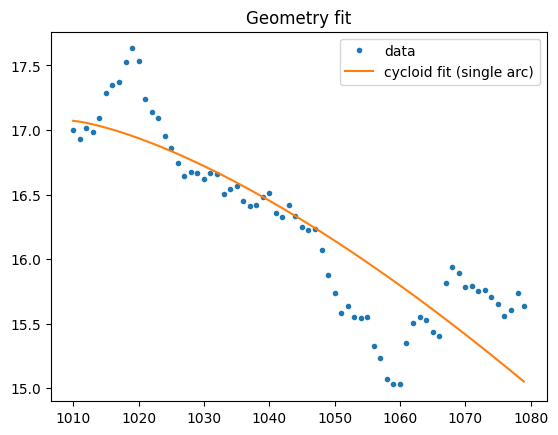

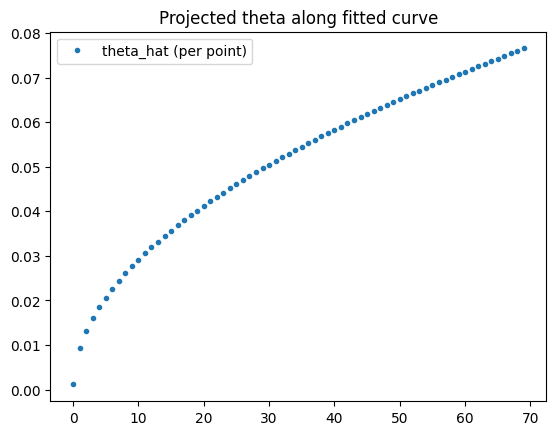

0.09584202475531248 0.07650947651282021 `ftol` termination condition is satisfied.


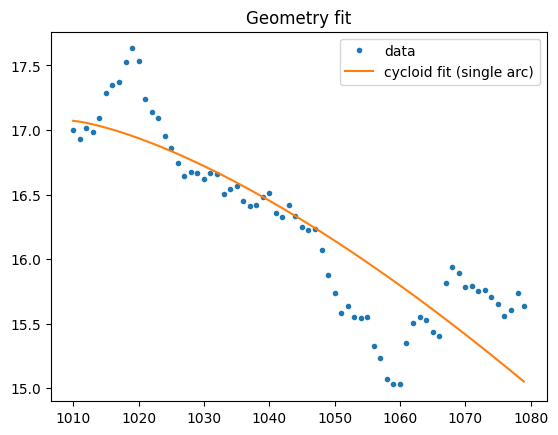

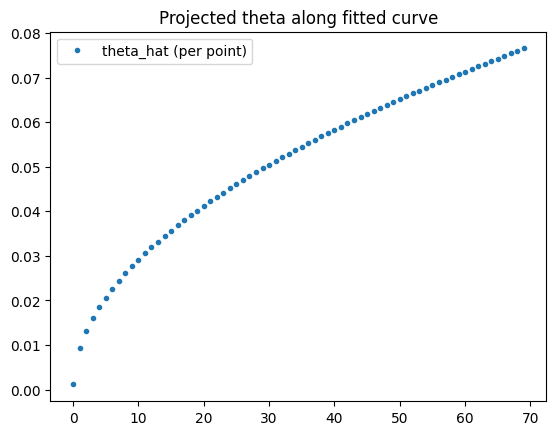

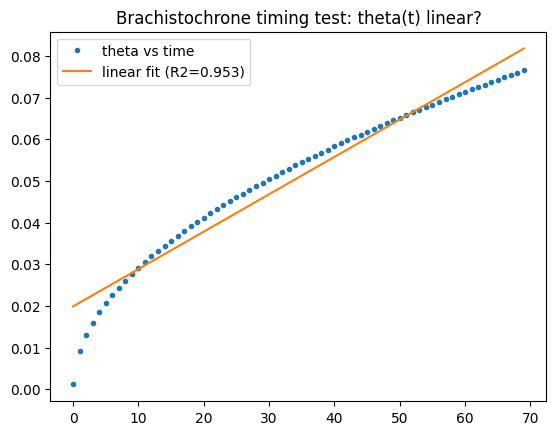

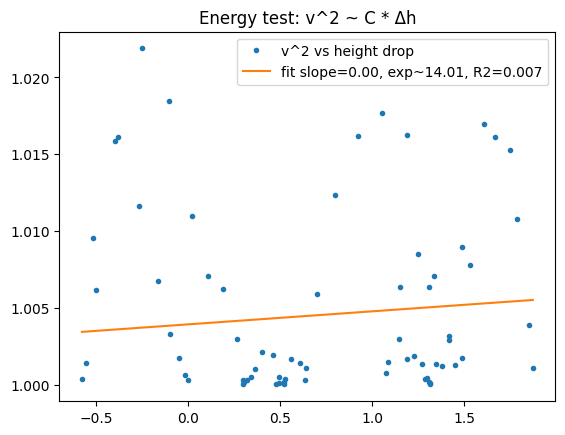

0.09584202475531248 0.07650947651282021 `ftol` termination condition is satisfied.
theta(t) R2: 0.9529470048488008
energy R2: 0.007467865730609313
energy slope: 0.0008487358112050354 expected: 14.014285714285716


In [205]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.signal import savgol_filter

# ----------------------------
# Cycloid + helpers
# ----------------------------
def rot(phi):
    c, s = np.cos(phi), np.sin(phi)
    return np.array([[c, -s],
                     [s,  c]])

def cycloid_xy(theta, a):
    # native cycloid coords (y down)
    return a * (theta - np.sin(theta)), a * (1 - np.cos(theta))

def softplus(u):
    return np.log1p(np.exp(-np.abs(u))) + np.maximum(u, 0)

def normalize_xy(x, y, isotropic=True):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    x_mean, y_mean = x.mean(), y.mean()
    sx, sy = x.std() + 1e-12, y.std() + 1e-12

    if isotropic:
        s = np.sqrt(sx * sy)
        xn = (x - x_mean) / s
        yn = (y - y_mean) / s
        stats = (x_mean, y_mean, s, s, True)
    else:
        xn = (x - x_mean) / sx
        yn = (y - y_mean) / sy
        stats = (x_mean, y_mean, sx, sy, False)

    return xn, yn, stats

def denormalize_xy(xn, yn, stats):
    x_mean, y_mean, sx, sy, _ = stats
    x = xn * sx + x_mean
    y = yn * sy + y_mean
    return x, y

# ----------------------------
# Single-arc cycloid fitting
# (prevents interior cusp by constraining theta in [0, theta_end<2π])
# ----------------------------
def residuals_single_arc(params, x_obs, y_obs):
    # params: [a, x0, y0, phi, theta_end, u0..u_{N-1}]
    a, x0, y0, phi, theta_end = params[:5]
    u = params[5:]
    N = len(u)

    d = softplus(u) + 1e-6
    s = np.cumsum(d)
    s = (s - s[0]) / (s[-1] - s[0] + 1e-12)   # [0,1]
    theta = theta_end * s                    # [0, theta_end]

    x_c, y_c = cycloid_xy(theta, a)
    pts = rot(phi) @ np.vstack([x_c, y_c])

    x_fit = x0 + pts[0]
    y_fit = y0 + pts[1]

    return np.concatenate([x_fit - x_obs, y_fit - y_obs])

def fit_cycloid_single_arc(x, y, isotropic=True, max_nfev=50000):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    N = len(x)
    if N < 6:
        raise ValueError("Need at least ~6 points to fit reliably.")

    xn, yn, stats = normalize_xy(x, y, isotropic=isotropic)

    # init
    dx, dy = xn[-1] - xn[0], yn[-1] - yn[0]
    phi0 = -np.arctan2(dy, dx)
    a0 = 1.0
    x0, y0 = xn[0], yn[0]
    theta_end0 = 3.0  # safe (< 2π)
    u0 = np.full(N, -1.0)

    p0 = np.concatenate([[a0, x0, y0, phi0, theta_end0], u0])

    lb = np.concatenate([[1e-6, -np.inf, -np.inf, -np.inf, 1e-3], -np.inf*np.ones(N)])
    ub = np.concatenate([[np.inf,  np.inf,  np.inf,  np.inf, 2*np.pi - 1e-3], np.inf*np.ones(N)])

    res = least_squares(
        residuals_single_arc,
        p0,
        bounds=(lb, ub),
        args=(xn, yn),
        loss="soft_l1",
        max_nfev=max_nfev
    )
    params = res.x[:5]  # (a, x0, y0, phi, theta_end) all in normalized space
    return res, params, stats

def reconstruct_curve(params, stats, n_points=400):
    a, x0, y0, phi, theta_end = params
    th = np.linspace(0.0, theta_end, n_points)
    x_c, y_c = cycloid_xy(th, a)
    pts = rot(phi) @ np.vstack([x_c, y_c])
    x_fit_n = x0 + pts[0]
    y_fit_n = y0 + pts[1]
    return denormalize_xy(x_fit_n, y_fit_n, stats)

# ----------------------------
# Projection: point -> best theta on fitted curve
# (approximate via grid search; robust + simple)
# ----------------------------
def project_points_to_theta(x, y, params, stats, n_grid=4000):
    a, x0, y0, phi, theta_end = params

    # normalize points
    xn, yn, _ = normalize_xy(x, y, isotropic=stats[4])  # uses same isotropic flag
    # BUT normalize_xy recomputes means; we need same mean/scale.
    # So do it manually using stats:
    x_mean, y_mean, sx, sy, _ = stats
    xn = (np.asarray(x) - x_mean) / sx
    yn = (np.asarray(y) - y_mean) / sy

    th = np.linspace(0.0, theta_end, n_grid)
    x_c, y_c = cycloid_xy(th, a)
    curve = rot(phi) @ np.vstack([x_c, y_c])
    cx = x0 + curve[0]
    cy = y0 + curve[1]

    # For each point, find closest grid theta (O(N*n_grid), OK for small N)
    theta_hat = np.empty(len(xn))
    dist2 = np.empty(len(xn))
    for i in range(len(xn)):
        dx = cx - xn[i]
        dy = cy - yn[i]
        d2 = dx*dx + dy*dy
        j = np.argmin(d2)
        theta_hat[i] = th[j]
        dist2[i] = d2[j]

    # return theta in radians, and distance in WORLD units:
    # dist in normalized -> convert to world approx using sx,sy
    # (distance is 2D; use anisotropic map)
    dist_world = np.sqrt(dist2 * (sx*sx + sy*sy)/2.0)  # rough; see rmse below for precise
    return theta_hat, dist2

def orthogonal_rmse_from_projection(dist2_norm, stats):
    # dist2_norm is squared distance in normalized coords (x and y already scaled)
    # Convert to world distance approximately by mapping residual components;
    # Here we provide a consistent RMSE in "normalized distance" and "approx world distance".
    x_mean, y_mean, sx, sy, _ = stats
    rmse_norm = np.sqrt(np.mean(dist2_norm))
    # Approx world (if isotropic normalization, sx==sy and this is exact up to that scale)
    rmse_world_approx = rmse_norm * 0.5 * (sx + sy)
    return rmse_norm, rmse_world_approx

# ----------------------------
# Kinematics: theta(t) linear + energy v^2 ~ delta_h
# ----------------------------
def fit_line(x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    X = np.vstack([np.ones_like(x), x]).T
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)  # [b0, b1]
    yhat = X @ beta
    resid = y - yhat
    ss_res = np.sum(resid**2)
    ss_tot = np.sum((y - y.mean())**2) + 1e-12
    r2 = 1 - ss_res/ss_tot
    return beta, r2, resid

def estimate_speed(t, x, y, smooth=True, window=9, poly=2):
    t = np.asarray(t, float)
    x = np.asarray(x, float)
    y = np.asarray(y, float)

    if smooth and len(t) >= window:
        x_s = savgol_filter(x, window_length=window, polyorder=poly)
        y_s = savgol_filter(y, window_length=window, polyorder=poly)
    else:
        x_s, y_s = x, y

    dt = np.gradient(t)
    dx = np.gradient(x_s) / dt
    dy = np.gradient(y_s) / dt
    v = np.sqrt(dx*dx + dy*dy)
    return v, x_s, y_s

def brachistochrone_tests(x, y, t=None, g=9.81, rolling_k=None,
                          isotropic=True, plot=True):
    """
    rolling_k = I/(mR^2). For solid sphere k=2/5. If None, assume sliding bead.
    """
    # 1) Fit geometry
    res, params, stats = fit_cycloid_single_arc(x, y, isotropic=isotropic)
    x_fit, y_fit = reconstruct_curve(params, stats)

    # 2) Project points -> theta
    theta_hat, dist2_norm = project_points_to_theta(x, y, params, stats)
    rmse_norm, rmse_world_approx = orthogonal_rmse_from_projection(dist2_norm, stats)

    out = {
        "fit_success": bool(res.success),
        "fit_message": res.message,
        "params_norm": params,    # (a, x0, y0, phi, theta_end) in normalized coords
        "theta_end": params[4],
        "rmse_norm": rmse_norm,
        "rmse_world_approx": rmse_world_approx,
        "theta_hat": theta_hat,
    }

    # 3) Timing law: theta ~ omega*t + theta0
    if t is not None:
        beta_theta, r2_theta, resid_theta = fit_line(t, theta_hat)
        out["theta_time_beta"] = beta_theta   # [theta0, omega]
        out["theta_time_r2"] = float(r2_theta)

        # 4) Energy law: v^2 ~ C * delta_h
        v, x_s, y_s = estimate_speed(t, x, y, smooth=True)
        # define height drop using y(0) - y(t) if y is "upwards".
        # If your y axis points DOWN, swap sign accordingly.
        # We can't know that automatically, so we use delta_h = y0 - y
        delta_h = (y_s[0] - y_s)

        # Use only where delta_h positive (after it starts descending)
        mask = delta_h > np.percentile(delta_h, 10)
        C_beta, r2_energy, resid_energy = fit_line(delta_h[mask], (v[mask]**2))

        out["energy_beta"] = C_beta  # v^2 = b0 + b1 * delta_h
        out["energy_r2"] = float(r2_energy)

        # expected slope
        if rolling_k is None:
            expected_slope = 2 * g
        else:
            expected_slope = 2 * g / (1.0 + rolling_k)

        out["energy_expected_slope"] = expected_slope

    # plots
    if plot:
        plt.figure()
        plt.plot(x, y, ".", label="data")
        plt.plot(x_fit, y_fit, "-", label="cycloid fit (single arc)")
        plt.title("Geometry fit")
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(theta_hat, ".", label="theta_hat (per point)")
        plt.title("Projected theta along fitted curve")
        plt.legend()
        plt.show()

        if t is not None:
            plt.figure()
            plt.plot(t, theta_hat, ".", label="theta vs time")
            # fitted line
            theta0, omega = out["theta_time_beta"]
            tt = np.linspace(np.min(t), np.max(t), 200)
            plt.plot(tt, theta0 + omega * tt, "-", label=f"linear fit (R2={out['theta_time_r2']:.3f})")
            plt.title("Brachistochrone timing test: theta(t) linear?")
            plt.legend()
            plt.show()

            v, x_s, y_s = estimate_speed(t, x, y, smooth=True)
            delta_h = (y_s[0] - y_s)
            plt.figure()
            plt.plot(delta_h, v**2, ".", label="v^2 vs height drop")
            if "energy_beta" in out:
                b0, b1 = out["energy_beta"]
                hh = np.linspace(np.min(delta_h), np.max(delta_h), 200)
                plt.plot(hh, b0 + b1*hh, "-", label=f"fit slope={b1:.2f}, exp~{out['energy_expected_slope']:.2f}, R2={out['energy_r2']:.3f}")
            plt.title("Energy test: v^2 ~ C * Δh")
            plt.legend()
            plt.show()

    return out


# ----------------------------
# Example usage
# ----------------------------
# You MUST supply real x,y in spatial units for a real brachistochrone test.
# If you only have a time series, you can still run geometry-only (t=None).

t1, t2 = 1010,1080
x = test_df.index.values[t1:t2]
t = np.arange(t2 - t1) 
y = test_df.AVG.values[t1:t2]

# Example (geometry-only):
out = brachistochrone_tests(x, y, t=None, plot=True)
print(out["rmse_norm"], out["theta_end"], out["fit_message"])

# Example (with time):
out = brachistochrone_tests(x, y, t=t, rolling_k=2/5, plot=True)
print(out["rmse_norm"], out["theta_end"], out["fit_message"])
print("theta(t) R2:", out["theta_time_r2"])
print("energy R2:", out["energy_r2"])
print("energy slope:", out["energy_beta"][1], "expected:", out["energy_expected_slope"])



            model         AIC         BIC        RSS  \
1     exponential -157.407446 -152.910456   6.977388   
0          linear -155.486378 -150.989387   7.171526   
2     logarithmic -154.486753 -147.741267   7.069766   
3  saturating_exp  -46.905935  -40.160450  32.874463   
4        logistic  -46.905906  -40.160420  32.874477   

                                              params  
1       [113.34755941271273, -0.0018612509414330913]  
0         [47.55853761484312, -0.029990193325731836]  
2  [234.34896298875086, -31.378483464900615, 1.27...  
3  [16.233751486283147, 2.396417834287705, 813.15...  
4  [32.46755883775346, 1.0000000000000003e-09, 88...  
--- Model: logistic_4p ---
Fitted Parameters: L=17.22, U=15.53, k=0.14, x0=1038.69
R²: 0.8791
RMSE: 0.2383
RMSE/Std: 0.3478 | RMSE/Mean: 0.0147 | RMSE/Range: 0.0916


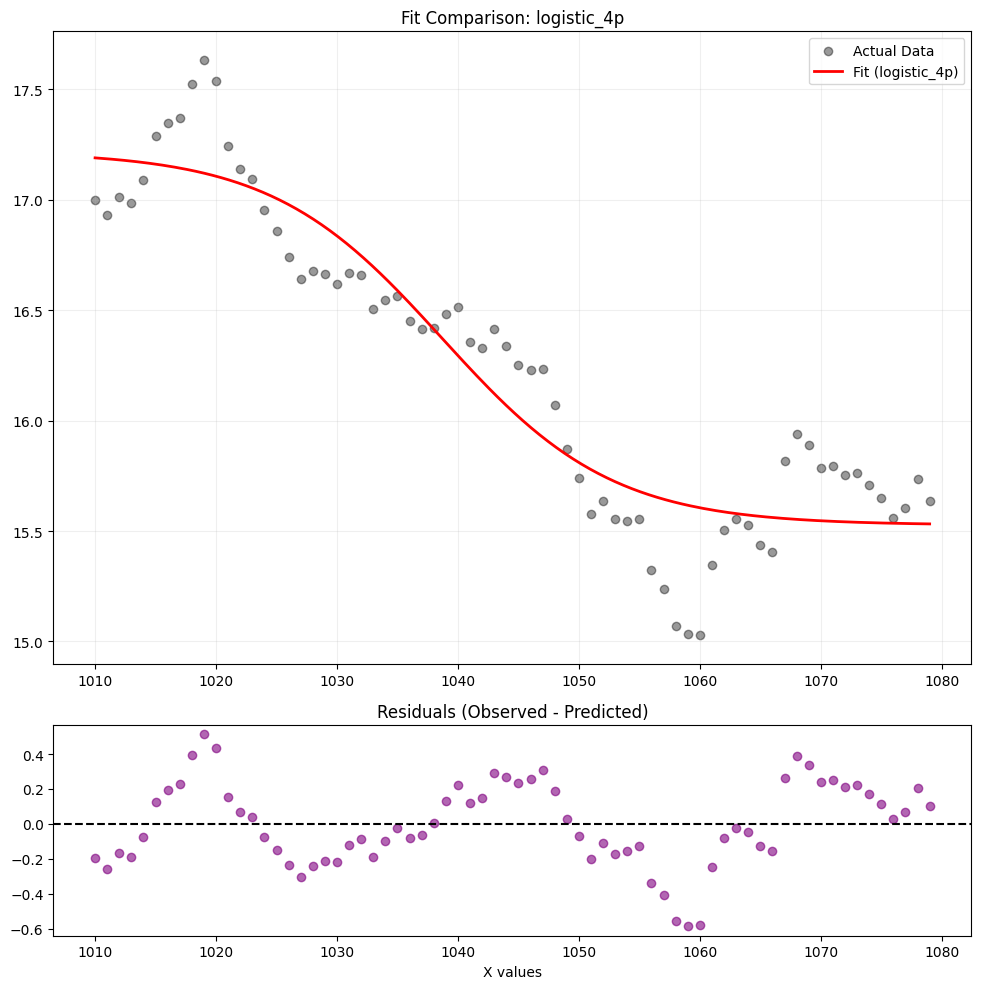

g vs time slope (should be ~0 for exponential): 1.3417751261718932e-05 p: 0.7633106951611843
g vs y slope (should be <0 for logistic): -0.0010917541678183908 p: 0.3972742214095647


In [195]:
# ---------- Usage ----------
# Suppose you have a DataFrame df with columns: 't' and 'y'
t1 = 1010
t2 = 1080

t = test_df.index.values[t1:t2]
y = test_df.AVG.values[t1:t2]

df_models, raw = compare_models(t, y)
print(df_models)
simple_fit_and_plot(test_df.index[t1:t2], test_df.AVG[t1:t2], logistic_4p)
import numpy as np
from scipy.stats import linregress

t = np.asarray(t, float)
y = np.asarray(y, float)

# avoid zeros/negatives
mask = y > 0
t, y = t[mask], y[mask]

dt = np.diff(t)
dy = np.diff(y)

# discrete per-capita growth rate
g = (dy/dt) / y[:-1]          # ~ (1/y) dy/dt
y_mid = y[:-1]

# exponential test: g ~ constant  (no trend vs time)
exp_test = linregress(t[:-1], g)

# logistic test: g ~ a + b*y with b < 0
logi_test = linregress(y_mid, g)

print("g vs time slope (should be ~0 for exponential):", exp_test.slope, "p:", exp_test.pvalue)
print("g vs y slope (should be <0 for logistic):", logi_test.slope, "p:", logi_test.pvalue)


           model  success    cv_rmse          aicc           bic  \
0    gompertz_4p     True   7.447250  26719.609535  26745.895503   
1     exp_affine     True   7.804504  26436.148481  26455.864094   
2  exp_unbounded     True   8.980999  26993.319835  27006.464334   
3    logistic_3p     True  10.034670  28093.364340  28113.079952   
4        sat_exp     True  16.559271  39911.169433  39930.885045   
5    logistic_4p     True        inf  26685.882257  26712.168225   

                                           params message  
0       [24.001535, 454.500693, 0.000446, 5288.0]      ok  
1                 [13.791107, 5.171773, 0.000676]      ok  
2                           [11.154028, 0.000536]      ok  
3                    [352.6468, 0.000721, 5288.0]      ok  
4                 [64.043322, 0.000786, 0.164849]      ok  
5  [18.557935, 352.732864, 0.000959, 5287.206612]      ok  


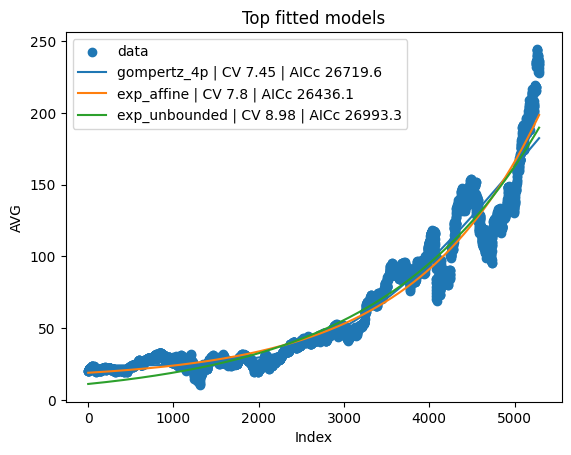

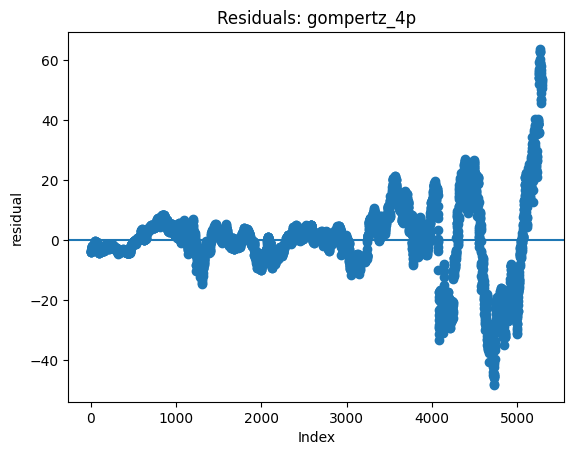

Best: gompertz_4p
  param[0]: 24.0015  95% CI [23.3246, 24.6785]
  param[1]: 454.501  95% CI [401.751, 507.251]
  param[2]: 0.00044645  95% CI [0.00041199, 0.00048091]
  param[3]: 5288  95% CI [5032.45, 5543.55]


In [111]:
df = test_df
df["Index"] = df.index
results = fit_and_compare(df, x_col="Index", y_col="AVG", min_train_cv=20, cv_step=5)
print(pd.DataFrame([{
     "model": r.name,
     "success": r.success,
     "cv_rmse": r.cv_rmse,
     "aicc": r.aicc,
     "bic": r.bic,
     "params": None if r.popt is None else np.round(r.popt, 6),
     "message": r.message
 } for r in results]))
#
plot_fits(df, results, x_col="Index", y_col="AVG", top_k=3)
best = results[0]
plot_residuals(df, best, x_col="Index", y_col="AVG")
#
# # Parameter CIs for best model
if best.success and best.pcov is not None:
     ci = param_ci(best.popt, best.pcov)
     if ci is not None:
         print("Best:", best.name)
         for i, (lo, hi) in enumerate(ci):
             print(f"  param[{i}]: {best.popt[i]:.6g}  95% CI [{lo:.6g}, {hi:.6g}]")

## Smoothing and denoising of prices

In [219]:
import numpy as np
import pandas as pd

def _add_interval_mass(mass, edges, a, b, w):
    """
    Add weight w uniformly over [a,b] into histogram bins defined by edges.
    If a==b (or b<a), add as a point-mass to the containing bin.
    """
    if w == 0 or np.isnan(w):
        return

    # order
    if b < a:
        a, b = b, a

    # point mass
    if b <= a:
        x = a
        # include right edge safely
        if x == edges[-1]:
            idx = len(mass) - 1
        else:
            idx = np.searchsorted(edges, x, side="right") - 1
        if 0 <= idx < len(mass):
            mass[idx] += w
        return

    left = np.maximum(edges[:-1], a)
    right = np.minimum(edges[1:], b)
    overlap = np.maximum(0.0, right - left)
    total = (b - a)
    if total > 0:
        mass += w * (overlap / total)

def price_distribution_from_ohlcv(
    df,
    idx0=900,                 # <-- time/index start (row index)
    idx1=1100,                # <-- time/index end (row index, inclusive)
    time_col=None,            # or provide a time column and slice by value
    time_start=None,
    time_end=None,
    price_min=None,           # <-- price range (optional)
    price_max=None,           # <-- price range (optional)
    n_bins=200,
    method="ohlc_path_avg",   # "uniform" or "ohlc_path_avg"
    weight_mode="vol_time",   # "time", "volume", "vol_time", "dollar_vol_time"
    duration_col=None,        # e.g. "dt_seconds" for irregular bars; else None
):
    # -------- 1) Slice the time window correctly --------
    if time_col is None:
        # row-index based slice (inclusive)
        idx0_i = int(max(0, idx0))
        idx1_i = int(min(len(df) - 1, idx1))
        dfx = df.iloc[idx0_i:idx1_i + 1].copy()
    else:
        if time_start is None or time_end is None:
            raise ValueError("If time_col is set, you must pass time_start and time_end.")
        dfx = df.loc[(df[time_col] >= time_start) & (df[time_col] <= time_end)].copy()

    if len(dfx) == 0:
        raise ValueError("Empty time window after slicing. Check idx0/idx1 or time filters.")

    # -------- 2) Choose price range for bins --------
    O = dfx["Open"].to_numpy(float)
    H = dfx["High"].to_numpy(float)
    L = dfx["Low"].to_numpy(float)
    C = dfx["Close"].to_numpy(float)
    V = dfx["Volume"].to_numpy(float)

    if duration_col is None:
        D = np.ones(len(dfx), dtype=float)
    else:
        D = dfx[duration_col].to_numpy(float)
        D = np.where(np.isfinite(D) & (D > 0), D, 0.0)

    if price_min is None:
        price_min = np.nanmin(L)
    if price_max is None:
        price_max = np.nanmax(H)

    if not np.isfinite(price_min) or not np.isfinite(price_max) or price_max <= price_min:
        raise ValueError("Invalid price_min/price_max. Check your OHLC columns.")

    edges = np.linspace(price_min, price_max, n_bins + 1)
    mass = np.zeros(n_bins, dtype=float)

    # -------- 3) Bar weights + mass allocation --------
    # Clip each bar to the price window for speed
    hi_clip = np.minimum(H, price_max)
    lo_clip = np.maximum(L, price_min)
    keep = hi_clip >= lo_clip  # NOTE: >= so flat bars survive

    for o, h, l, c, v, d, a, b, k in zip(O, H, L, C, V, D, lo_clip, hi_clip, keep):
        if not k:
            continue

        # scalar weight
        if weight_mode == "time":
            w = d
        elif weight_mode == "volume":
            w = v
        elif weight_mode == "vol_time":
            w = v * d
        elif weight_mode == "dollar_vol_time":
            tp = (h + l + c) / 3.0
            w = (v * tp) * d
        else:
            raise ValueError("Unknown weight_mode")

        if not np.isfinite(w) or w == 0:
            continue

        if method == "uniform":
            # uniform across [L,H] (clipped)
            _add_interval_mass(mass, edges, a, b, w)

        elif method == "ohlc_path_avg":
            # average of two plausible paths
            paths = ([o, h, l, c], [o, l, h, c])

            for pts in paths:
                # build segments
                segs = list(zip(pts[:-1], pts[1:]))
                lengths = np.array([abs(bb - aa) for aa, bb in segs], dtype=float)
                total_len = lengths.sum()

                if total_len == 0:
                    # flat bar: put full (half-path) mass at the (any) price, use Close
                    _add_interval_mass(mass, edges, pts[-1], pts[-1], w * 0.5)
                    continue

                # allocate half of w to this path
                w_path = w * 0.5
                for (x0, x1), Lseg in zip(segs, lengths):
                    if Lseg == 0:
                        continue
                    wseg = w_path * (Lseg / total_len)

                    # add segment uniformly, clipped to [price_min, price_max]
                    lo_s, hi_s = (x0, x1) if x0 <= x1 else (x1, x0)
                    lo_s = max(lo_s, price_min)
                    hi_s = min(hi_s, price_max)
                    _add_interval_mass(mass, edges, lo_s, hi_s, wseg)

        else:
            raise ValueError("Unknown method")

    # -------- 4) Normalize --------
    mids = 0.5 * (edges[:-1] + edges[1:])
    widths = np.diff(edges)
    total_mass = mass.sum()

    if total_mass <= 0:
        raise ValueError(
            "Total mass is 0. Most common causes:\n"
            "1) wrong time slice (idx0/idx1),\n"
            "2) wrong price range (price_min/price_max),\n"
            "3) Volume/Duration are all 0/NaN."
        )

    prob = mass / total_mass
    cdf = np.cumsum(prob)
    pdf = prob / widths  # density estimate per unit price

    out = pd.DataFrame({
        "bin_left": edges[:-1],
        "bin_right": edges[1:],
        "bin_mid": mids,
        "mass": mass,
        "prob": prob,
        "pdf": pdf,
        "cdf": cdf,
    })

    return out


In [267]:
dist = price_distribution_from_ohlcv(
    df,
    idx0=800,
    idx1=1080,
    n_bins=100,
    method="ohlc_path_avg",
    weight_mode="vol_time",   # or "dollar_vol_time"
)

dist

,bin_left,bin_right,bin_mid,mass,prob,pdf,cdf
0,14.364504,14.404705,14.384605,4.699758e+06,0.000265,0.006584,0.000265
1,14.404705,14.444906,14.424806,4.699758e+06,0.000265,0.006584,0.000529
2,14.444906,14.485107,14.465007,1.183901e+07,0.000667,0.016586,0.001196
3,14.485107,14.525308,14.505208,2.472015e+07,0.001392,0.034631,0.002588
4,14.525308,14.565509,14.545409,2.496585e+07,0.001406,0.034976,0.003994
...,...,...,...,...,...,...,...
95,18.183596,18.223797,18.203697,2.257056e+07,0.001271,0.031620,0.996612
96,18.223797,18.263998,18.243898,1.682506e+07,0.000948,0.023571,0.997559
97,18.263998,18.304199,18.284099,1.628709e+07,0.000917,0.022817,0.998476
98,18.304199,18.344400,18.324300,1.628709e+07,0.000917,0.022817,0.999394


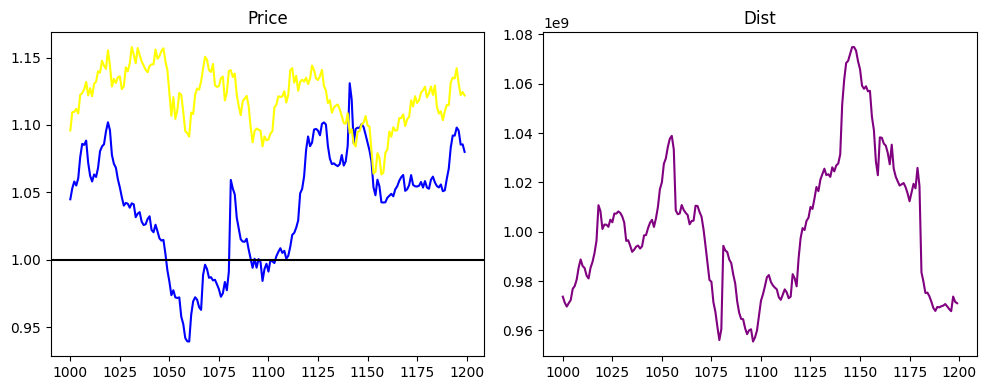

In [333]:
t1, t2 = 1000,1200
x = test_df.index.values[t1:t2]
y = test_df.AVG.values[t1:t2]
MA10 = test_df.MA10.values[t1:t2]
MA20 = test_df.MA20.values[t1:t2]
MA40 = test_df.MA40.values[t1:t2]
MA100 = test_df.MA100.values[t1:t2]
E = (dist["bin_mid"] * dist["prob"]).sum()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(x, y/16, color='blue')
ax1.plot(df.Close[t1:t2]/1000, color = "yellow")
#ax1.plot(x, MA20/16, color='red')
#ax1.plot(x, MA40/16, color='orange')
#ax1.plot(x, MA100/16, color='yellow')
ax1.axhline(y = 1, color = "black")
ax1.set_title('Price')

ax2.plot(x, p[t1:t2], color='purple')
#ax2.barh(dist["bin_mid"], dist["mass"])
ax2.set_title('Dist')

plt.tight_layout()
plt.show()


In [223]:
#dist["prob"].sum()          # should be 1.0 (up to floating error)
dist["cdf"].iloc[-1]        # should be ~1.0
#dist.loc[dist.prob > 0].shape[0]  # how many bins got mass


np.float64(0.9999999999999997)

# Physics

Position = price \
velocity = returns = d1t price \
acceleration = ? = d2t price \
mass = measure of liquidity? = dp/dt + nabla * p * v, where p is density, nabla * = d/dx + d/dy + d/dz +...

In [43]:
v = df.Close.diff() / df.Close.shift(1)
a = v.diff() / v.shift(1)
s =  df.Close.rolling(window=100).std() 
h = df.Low.rolling(window=100).min()
m = df.High.rolling(window = 252).max()

In [44]:
np.mean(v[2500:4800])/np.mean(v[0:2000])
#np.mean(v)*100

np.float64(0.5904950298114251)

In [83]:
m = df.Volume * v

In [81]:
m = df.Volume / df.Volume.rolling(window=100).mean()
m2 = df.Volume.diff() / df.Volume.shift(1)

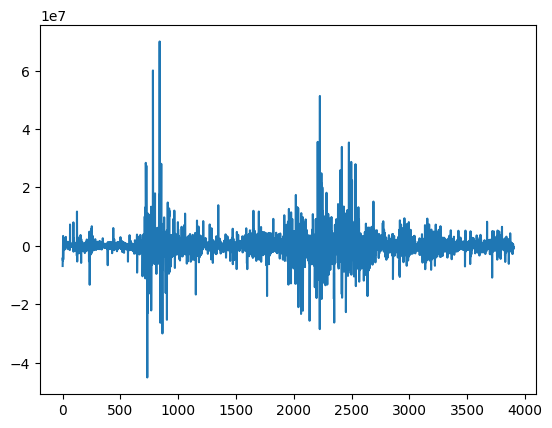

In [84]:
#plt.plot(np.log(df.Close)/10)
plt.plot(m)
#plt.plot(m2)
#plt.xlim(2500,4800)
#plt.ylim(-100,100)

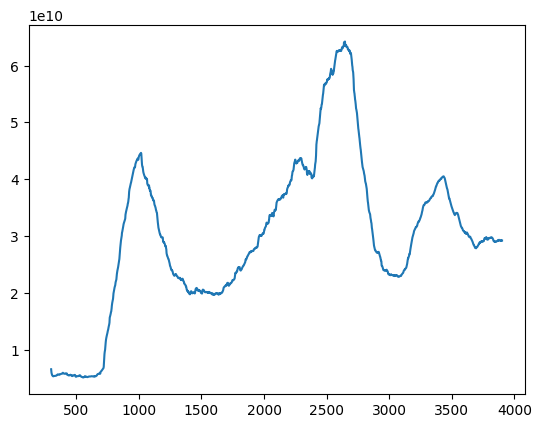

In [51]:
#plt.plot(h)
plt.plot(df.Volume.rolling(window=300).sum())
#plt.xlim(2500,4800)
#plt.ylim(-100,100)

In [347]:
m = test_df.Volume.rolling(window = 100).mean()
h = test_df.AVG.rolling(window=100).min()
p = m * h

1.2978939043862006
0.6678971330331656


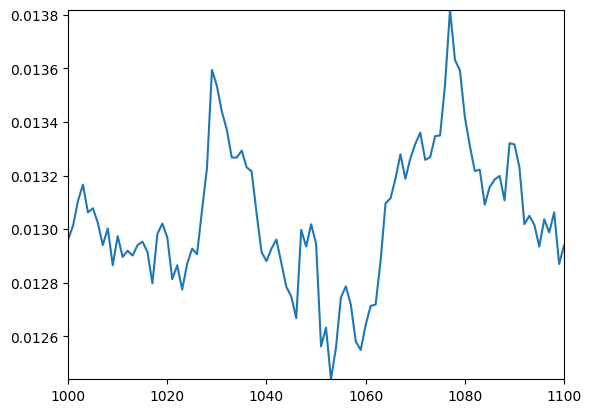

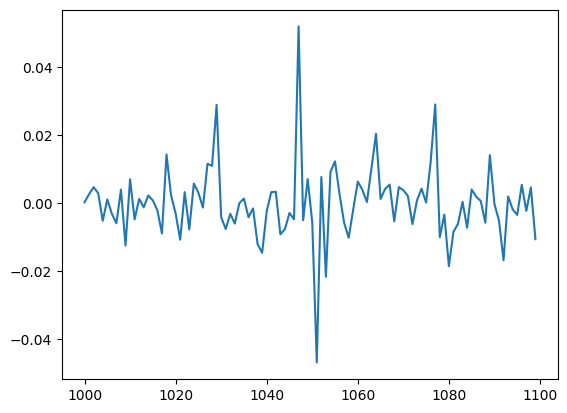

-3.0261988254118995e-05
-8.898501630662803e-05


In [4]:
t1, t2 = 1000,1100
plt.plot(df.Close/1000)
plt.xlim(t1,t2)
plt.ylim(min(df.Close[t1:t2])/1000,max(df.Close[t1:t2])/1000)
plt.show()

m = df.Volume/2
m_avg = 0.6*df.Volume.rolling(window = 100).mean()
v = df.Close.diff() / df.Close.shift(1)
k =  m/m_avg * v
plt.plot(k[t1:t2])
plt.show()

print(np.mean(k))
print(np.mean(k[t1:t2]))